In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import os

In [59]:
TRAIN_TFRECORD_FILENAME = "train.tfrecord"
VALID_TFRECORD_FILENAME = "valid.tfrecord"
TEST_TFRECORD_FILENAME = "test.tfrecord"
SPECTROGRAM_TRAIN_TFRECORD_FILENAME = "spectrogram_train.tfrecord"
SPECTROGRAM_VALID_TFRECORD_FILENAME = "spectrogram_valid.tfrecord"
SPECTROGRAM_TEST_TFRECORD_FILENAME = "spectrogram_test.tfrecord"
DATA_DIR = "data"
SAMPLING_RATE = 44100

# Load data

In [10]:
train_dataset = tf.data.TFRecordDataset([os.path.join(DATA_DIR, TRAIN_TFRECORD_FILENAME)])
valid_dataset = tf.data.TFRecordDataset([os.path.join(DATA_DIR, VALID_TFRECORD_FILENAME)])
test_dataset = tf.data.TFRecordDataset([os.path.join(DATA_DIR, TEST_TFRECORD_FILENAME)])

In [11]:
feature_description = {
    'waveform': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label': tf.io.FixedLenFeature([], tf.float32, default_value=0.0)
}

def _parse_function(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    waveform = tf.io.parse_tensor(example['waveform'], out_type=tf.float32)
    waveform = tf.ensure_shape(waveform, (SECTION_SIZE, 2))
    label = tf.ensure_shape(example['label'], ())
    return waveform, label

In [12]:
train_dataset = train_dataset.map(_parse_function)
valid_dataset = valid_dataset.map(_parse_function)
test_dataset = test_dataset.map(_parse_function)

In [13]:
for i in train_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(11025, 2), dtype=float32, numpy=
array([[-0.08157349, -0.07055664],
       [-0.07818604, -0.07647705],
       [-0.06790161, -0.07702637],
       ...,
       [-0.04818726,  0.04501343],
       [-0.04989624,  0.059021  ],
       [-0.04837036,  0.07107544]], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)


# STFT

Referenced tutorial: https://www.tensorflow.org/tutorials/audio/simple_audio

Explainer Paper on STFT: https://www.jstage.jst.go.jp/article/jasj/72/12/72_764/_pdf (Japanese)

In [38]:
def get_spectrograms(waveform):
    spectrogram1 = tf.signal.stft(waveform[:, 0], frame_length=256, frame_step=128)
    spectrogram1 = tf.abs(spectrogram1)
    spectrogram2 = tf.signal.stft(waveform[:, 1], frame_length=256, frame_step=128)
    spectrogram2 = tf.abs(spectrogram2)
    return spectrogram1, spectrogram2

In [39]:
for waveform, label in train_dataset.take(1):
    spectrogram1, spectrogram2 = get_spectrograms(waveform)
    print("Waveform shape:", waveform.shape)
    print("Spectrogram shape:", spectrogram1.shape)

Label: 0.0
Waveform shape: (11025, 2)
Spectrogram shape: (85, 129)


In [42]:
# Borrowed from tutorial
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [45]:
def plot_waveform_and_spectrograms(waveform, spectrograms):
    fig, axes = plt.subplots(3, figsize=(12, 12))
    timescale = np.arange(waveform.shape[0])
    axes[0].plot(timescale, waveform.numpy(), c='blue')
    axes[0].set_title('Waveform')
    axes[0].set_xlim([0, SAMPLING_RATE // 4])
    plot_spectrogram(spectrograms[0].numpy(), axes[1])
    axes[1].set_title('Spectrogram 1')
    plot_spectrogram(spectrograms[1].numpy(), axes[2])
    axes[2].set_title('Spectrogram 2')
    plt.show()

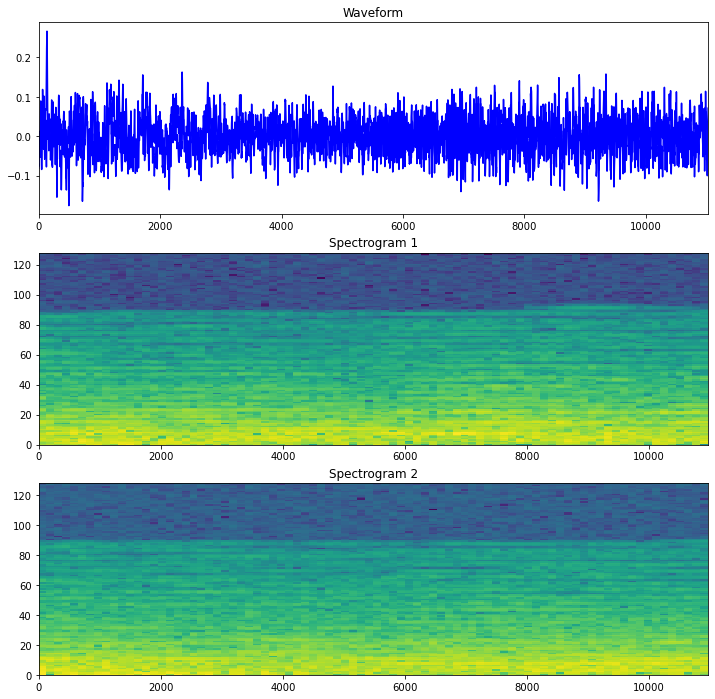

In [48]:
for w, l in train_dataset:
    if l == 0.0:
        plot_waveform_and_spectrograms(w, get_spectrograms(w))
        break

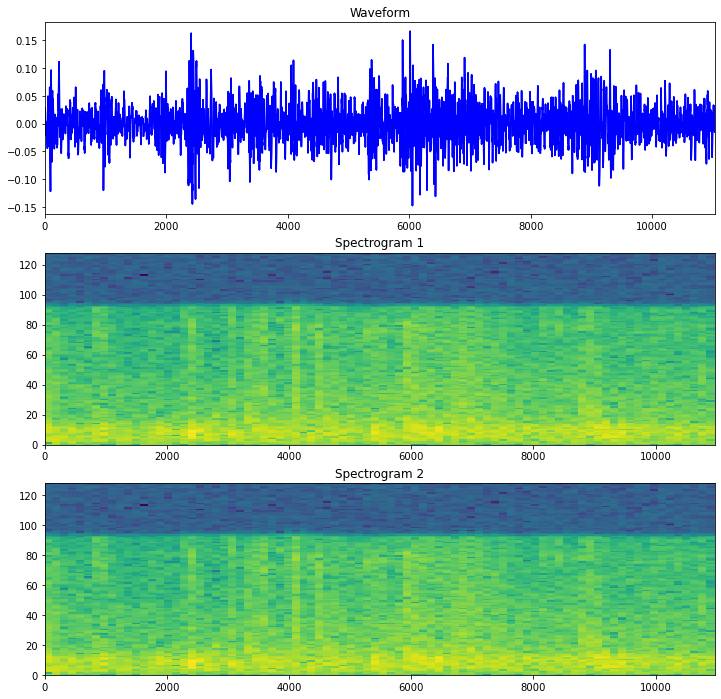

In [49]:
for w, l in train_dataset:
    if l == 1.0:
        plot_waveform_and_spectrograms(w, get_spectrograms(w))
        break

One can observe by inspection that the applause spectrogram (l == 1.0) is quite "noisy" while the classical music waveform is "smooth". Let's see if a neural network can pick this nuance up.

Since the two spectrograms are nearly identical, for the purposes of this classification study, it should suffice to use only one spectrogram.

# Dataset Transform

In [51]:
def spectrogram_and_label(waveform, label):
    spectrogram, _ = get_spectrograms(waveform)
    return spectrogram, label

In [54]:
spectrogram_train_dataset = train_dataset.map(spectrogram_and_label)
spectrogram_valid_dataset = valid_dataset.map(spectrogram_and_label)
spectrogram_test_dataset = test_dataset.map(spectrogram_and_label)

# Export

In [56]:
def serialize_example(spectrogram, label):
    spectrogram_serialized = tf.io.serialize_tensor(spectrogram)
    feature = {
        'spectrogram': tf.train.Feature(bytes_list=tf.train.BytesList(value=[spectrogram_serialized.numpy()])),
        'label': tf.train.Feature(float_list=tf.train.FloatList(value=[label.numpy()]))
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [57]:
def tf_serialize_example(spectrogram, label):
    tf_string = tf.py_function(
        serialize_example,
        (spectrogram, label),
        tf.string)
    return tf.reshape(tf_string, ())

In [58]:
spectrogram_serialized_train_dataset = spectrogram_train_dataset.map(tf_serialize_example)
spectrogram_serialized_valid_dataset = spectrogram_valid_dataset.map(tf_serialize_example)
spectrogram_serialized_test_dataset = spectrogram_test_dataset.map(tf_serialize_example)

In [60]:
train_writer = tf.data.experimental.TFRecordWriter(os.path.join(DATA_DIR, SPECTROGRAM_TRAIN_TFRECORD_FILENAME))
train_writer.write(spectrogram_serialized_train_dataset)
valid_writer = tf.data.experimental.TFRecordWriter(os.path.join(DATA_DIR, SPECTROGRAM_VALID_TFRECORD_FILENAME))
valid_writer.write(spectrogram_serialized_valid_dataset)
test_writer = tf.data.experimental.TFRecordWriter(os.path.join(DATA_DIR, SPECTROGRAM_TEST_TFRECORD_FILENAME))
test_writer.write(spectrogram_serialized_test_dataset)